In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import cv2


class ThreeBodyEnv(gym.Env):
    """
    A 3-Body Gravitational System.
    Action: Thrust vector applied to Body 1 (The 'Spaceship').
    State: [x1, y1, vx1, vy1, x2, y2, ... ] (12 dimensions)
    """

    metadata = {"render_modes": ["rgb_array"]}

    def __init__(self, render_mode=None):
        self.render_mode = render_mode
        self.dt = 0.05
        self.G = 1.0
        # Action: Thrust on Body 1 (x, y)
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(2,), dtype=np.float32
        )
        # Observation: positions and velocities of 3 bodies
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(12,), dtype=np.float32
        )

        self.state = None
        self.masses = np.array([1.0, 1.0, 1.0])  # Equal masses = Maximum Chaos

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Random initialization to ensure chaotic divergence
        # Positions clustered in center
        q = np.random.randn(6) * 1.0
        # Velocities slightly randomized to start orbit
        p = np.random.randn(6) * 0.5
        self.state = np.concatenate([q, p])
        return self.state, {}

    def step(self, action):
        # Symplectic Euler Integration (Semi-Implicit) for stability
        q = self.state[:6].reshape(3, 2)  # 3 bodies, 2 pos (x,y)
        p = self.state[6:].reshape(3, 2)  # 3 bodies, 2 vel (vx,vy)

        # Calculate Accelerations (Gravity)
        acc = np.zeros_like(q)
        for i in range(3):
            for j in range(3):
                if i != j:
                    r_vec = q[j] - q[i]
                    r_mag = (
                        np.linalg.norm(r_vec) + 1e-6
                    )  # Softening to prevent explosion
                    acc[i] += self.G * self.masses[j] * r_vec / (r_mag**3)

        # Apply Action (Thrust) to Body 0 only
        acc[0] += action * 2.0  # Strength of thruster

        # Update Velocity (p) then Position (q) - Symplectic
        p_new = p + acc * self.dt
        q_new = q + p_new * self.dt

        self.state = np.concatenate([q_new.flatten(), p_new.flatten()])

        # Render check
        terminated = False
        # Terminate if they fly too far away (unstable orbit)
        if np.any(np.abs(q_new) > 5.0):
            terminated = True

        return self.state, 0.0, terminated, False, {}

    def render(self):
        # Draw the bodies on a black canvas
        width, height = 64, 64  # Match your target res
        img = np.zeros((height, width, 3), dtype=np.uint8)
        scale = width / 10.0  # Scale world coordinates to pixels
        center = width / 2.0

        colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # R, G, B bodies

        q = self.state[:6].reshape(3, 2)
        for i in range(3):
            x = int(q[i, 0] * scale + center)
            y = int(q[i, 1] * scale + center)
            if 0 <= x < width and 0 <= y < height:
                cv2.circle(img, (x, y), 3, colors[i], -1)

        return img

In [3]:
import matplotlib.pyplot as plt

env = ThreeBodyEnv("rgd_array")
obs, info = env.reset()
print("obs", obs)

obs [ 1.30349187 -0.7958255  -1.30674197 -0.65243398 -0.09417701 -1.74497985
  0.00897579 -0.07981827  0.2039076  -0.61351779  0.08079271  0.23804564]


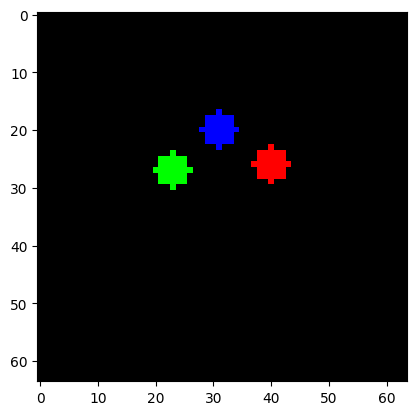

In [4]:
img = env.render()
plt.imshow(img)
plt.show()

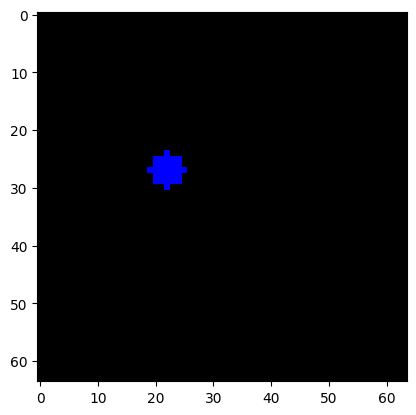

In [12]:
env = ThreeBodyEnv("rgd_array")
env.reset()
frames = []
for i in range(100):
    env.step(np.array([0.0, 0.0]))
    img = env.render()
    frames.append(img)

plt.imshow(frames[-1])
plt.show()

In [20]:
cat_frames = np.concatenate(np.array(frames[0:50]), axis=1)
cat_frames.shape

(64, 3200, 3)

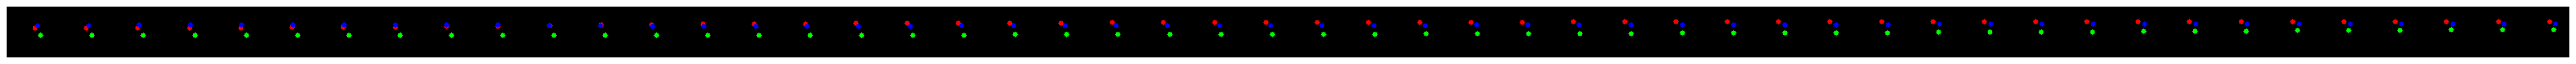

In [23]:
fig = plt.figure(figsize=(50, 50))
plt.imshow(cat_frames)
plt.axis("off")
plt.show()

In [35]:
import gymnasium as gym
import numpy as np
import h5py
import cv2
import os


def collect_trajectories(
    env_name, num_trajectories=100, max_steps=500, save_path="data"
):
    # Create env with render_mode='rgb_array' for pixel capture
    if env_name == "ThreeBody-v0":
        env = ThreeBodyEnv(render_mode="rgb_array")  # Defined in Step 4
    else:
        env = gym.make(env_name, render_mode="rgb_array")

    os.makedirs(save_path, exist_ok=True)
    filename = os.path.join(save_path, f"{env_name}_phase1.h5")

    with h5py.File(filename, "w") as f:
        # Create groups for flexible storage
        grp_imgs = f.create_group("images")
        grp_states = f.create_group("states")
        grp_actions = f.create_group("actions")

        print(f"Starting collection for {env_name}...")

        for i in range(num_trajectories):
            obs, info = env.reset()

            # Storage for this trajectory
            traj_imgs = []
            traj_states = []
            traj_actions = []

            for t in range(max_steps):
                # 1. Render Frame (Resize to 64x64 for standard World Model speed)
                img = env.render()
                img = cv2.resize(img, (64, 64))
                traj_imgs.append(img)

                # 2. Physics-Informed Action Policy (Mix of Random + Forcing)
                # We add a sine wave to "pump" the system into chaos/high-energy
                if isinstance(env.action_space, spaces.Box):
                    action_dim = env.action_space.shape[0]
                elif isinstance(env.action_space, spaces.Discrete):
                    action_dim = 1
                else:
                    raise ValueError(
                        f"Unknown action space: {type(env.action_space)}"
                    )
                forcing = np.sin(t * 0.1) * 2.0
                noise = np.random.normal(0, 1.0, size=action_dim)
                action = np.clip(
                    forcing + noise,
                    env.action_space.low,
                    env.action_space.high,
                )

                # 3. Step
                next_obs, reward, terminated, truncated, _ = env.step(action)

                # Store Data
                traj_states.append(obs)  # Ground truth physics state (q, p)
                traj_actions.append(action)

                obs = next_obs
                if terminated or truncated:
                    break

            # Save trajectory to HDF5
            grp_imgs.create_dataset(
                f"traj_{i}", data=np.array(traj_imgs, dtype=np.uint8)
            )
            grp_states.create_dataset(
                f"traj_{i}", data=np.array(traj_states, dtype=np.float32)
            )
            grp_actions.create_dataset(
                f"traj_{i}", data=np.array(traj_actions, dtype=np.float32)
            )

            if i % 10 == 0:
                print(f"Collected {i}/{num_trajectories} trajectories")

    env.close()
    print(f"Saved to {filename}")


# Run for Tier 1 & 2

# Tier 1: Physics Verification
collect_trajectories("Pendulum-v1", num_trajectories=1, max_steps=100)

# Tier 2: The World Model Challenge
# collect_trajectories("Acrobot-v1", num_trajectories=500, max_steps=500)

# Tier 3: Three Body (See Step 4)
# collect_trajectories("ThreeBody-v0", num_trajectories=500, max_steps=1000)

Starting collection for Pendulum-v1...
Collected 0/1 trajectories
Saved to data/Pendulum-v1_phase1.h5


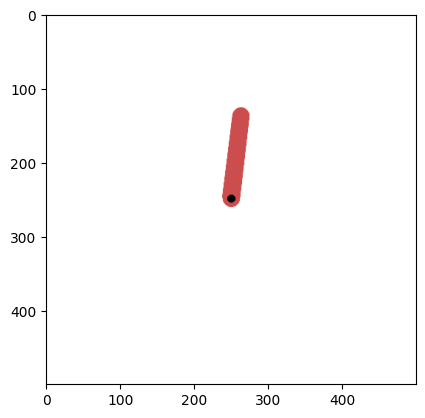

In [33]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")
env.reset()
img = env.render()
plt.imshow(img)
plt.show()

In [34]:
env.action_space

Box(-2.0, 2.0, (1,), float32)

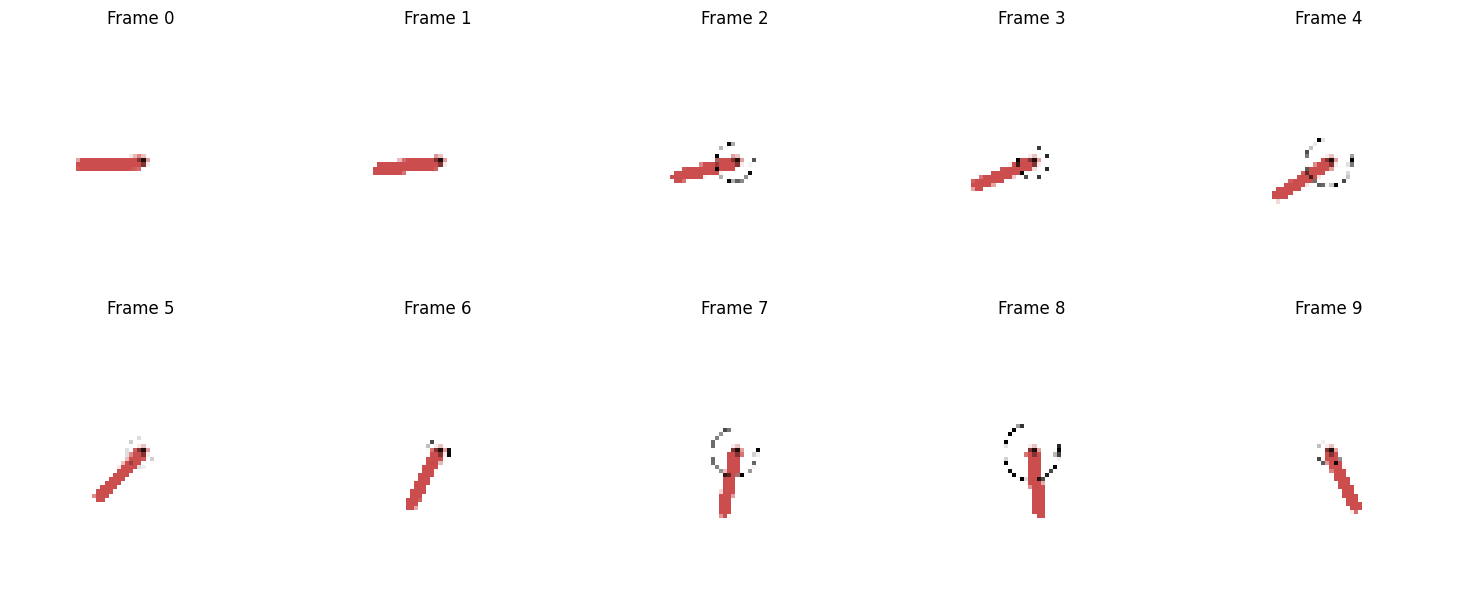

Loaded trajectory with 100 frames
Frame shape: (64, 64, 3)


In [27]:
# Load the saved trajectory
filename = "data/Pendulum-v1_phase1.h5"

with h5py.File(filename, "r") as f:
    # Load the first trajectory (traj_0)
    images = f["images/traj_0"][:]

    # Get first 10 frames
    first_10_frames = images[:10]

    # Visualize
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(10):
        axes[i].imshow(first_10_frames[i])
        axes[i].set_title(f"Frame {i}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Loaded trajectory with {len(images)} frames")
    print(f"Frame shape: {images[0].shape}")

In [36]:
collect_trajectories("Acrobot-v1", num_trajectories=1, max_steps=100)

Starting collection for Acrobot-v1...


AttributeError: 'Discrete' object has no attribute 'low'

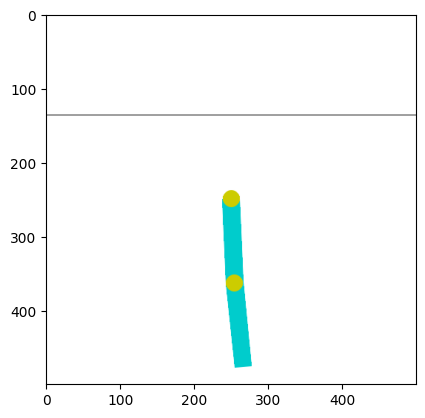

In [29]:
env = gym.make("Acrobot-v1", render_mode="rgb_array")
env.reset()
img = env.render()
plt.imshow(img)
plt.show()

In [32]:
env.observation_space

Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)